In [44]:
%matplotlib inline
import pandas as pd
from apyori import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from pyECLAT import ECLAT
import json
import pickle
from arulesviz import Arulesviz
from itertools import combinations, permutations

### Loading the dataset

In [45]:
with open('../data/processed/basket_item_sets.json', 'r') as f:
    transactions = json.load(f)
    
transactions

[['Gourmet brewed coffee'],
 ['Brewed Chai tea'],
 ['Hot chocolate'],
 ['Drip coffee'],
 ['Brewed Chai tea', 'Scone'],
 ['Drip coffee'],
 ['Gourmet brewed coffee'],
 ['Barista Espresso'],
 ['Hot chocolate'],
 ['Brewed Chai tea'],
 ['Gourmet brewed coffee'],
 ['Brewed Black tea'],
 ['Brewed Chai tea'],
 ['Barista Espresso'],
 ['Brewed Green tea', 'Scone'],
 ['Brewed herbal tea'],
 ['Hot chocolate'],
 ['Hot chocolate'],
 ['Gourmet brewed coffee'],
 ['Brewed Chai tea', 'Biscotti'],
 ['Brewed Chai tea'],
 ['Barista Espresso'],
 ['Brewed herbal tea', 'Biscotti'],
 ['Brewed herbal tea', 'Pastry'],
 ['Barista Espresso'],
 ['Barista Espresso'],
 ['Organic brewed coffee'],
 ['Organic brewed coffee'],
 ['Gourmet brewed coffee'],
 ['Brewed Chai tea'],
 ['Organic brewed coffee'],
 ['Brewed Chai tea'],
 ['Barista Espresso'],
 ['Brewed herbal tea'],
 ['Brewed herbal tea'],
 ['Drip coffee'],
 ['Hot chocolate', 'Scone'],
 ['Brewed Chai tea', 'Scone'],
 ['Brewed herbal tea'],
 ['Brewed Chai tea'],
 ['B

## Apriori
The **Apriori** algorithm is one of the most widely used techniques for association rule learning in data mining. It follows a bottom-up approach, beginning with individual items (1-itemsets) and progressively combining them to form larger sets, a process known as candidate generation.

At each step, the algorithm evaluates the candidate based on predefined thresholds for support, confidence, and lift. Only itemsets meeting these minimum requirements are retained for further exploration and inclusion in the final set of rules.

Apriori employs a Breadth-First Search (BFS) strategy, systematically exploring all possible itemsets of size k before moving to k + 1. It leverages the **downward closure** property, which states that an itemset is considered frequent only if **all its subsets are frequent**. The algorithm terminates when no new candidate itemsets can be generated or none meet the threshold criteria.

### Unique elements in our set of transactions

In [46]:
elements = set([item for transaction in transactions for item in transaction])

elements

{'Barista Espresso',
 'Biscotti',
 'Black tea',
 'Brewed Black tea',
 'Brewed Chai tea',
 'Brewed Green tea',
 'Brewed herbal tea',
 'Chai tea',
 'Clothing',
 'Drinking Chocolate',
 'Drip coffee',
 'Espresso Beans',
 'Gourmet Beans',
 'Gourmet brewed coffee',
 'Green beans',
 'Green tea',
 'Herbal tea',
 'Hot chocolate',
 'House blend Beans',
 'Housewares',
 'Organic Beans',
 'Organic Chocolate',
 'Organic brewed coffee',
 'Pastry',
 'Premium Beans',
 'Premium brewed coffee',
 'Regular syrup',
 'Scone',
 'Sugar free syrup'}

### Parameters

**Support**: i.e. the frequency, it measures how frequently elements of A occured in our transactions.

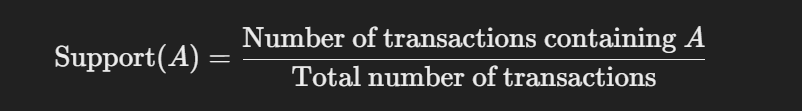


**Confidence**: measures how likely elements in B are to appear in transactions where elements of A are already present.

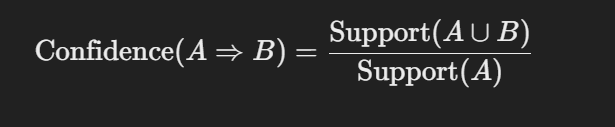

**Lift**: takes into consideration the frequency of B. It measures how likely B is to appear alongside A in comparison to B appearing independently.

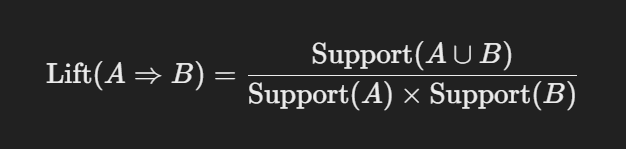

### Generating the list of rules based on our transactions, with support and confidence of 0.3% and 20%, respectively.

In [47]:
rules = list(
    apriori(
        transactions, 
        min_support=0.003, 
        min_confidence=0.2, 
        min_lift=3, 
        min_length=2
    )
)

print(*[rule for rule in rules], sep='\n')

RelationRecord(items=frozenset({'Barista Espresso', 'Regular syrup'}), support=0.04234095384878842, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Barista Espresso'}), items_add=frozenset({'Regular syrup'}), confidence=0.303579102461784, lift=7.133803496280031), OrderedStatistic(items_base=frozenset({'Regular syrup'}), items_add=frozenset({'Barista Espresso'}), confidence=0.9949698189134808, lift=7.133803496280031)])
RelationRecord(items=frozenset({'Sugar free syrup', 'Barista Espresso'}), support=0.015403716071581471, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Sugar free syrup'}), items_add=frozenset({'Barista Espresso'}), confidence=0.9939226519337017, lift=7.126295445965806)])
RelationRecord(items=frozenset({'Scone', 'Barista Espresso', 'Regular syrup'}), support=0.0035105745354910524, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Scone', 'Barista Espresso'}), items_add=frozenset({'Regular syrup'}), confidence=0.21601685985247632, lift=5.0

In [48]:
def associated_sets(element):
    if element not in elements:
        raise ValueError('Element does not exist')
    
    sets = set()
    
    for rule in rules:
        if element in rule.items:
            sets.add(rule.items)
            
    return sets

In [49]:
def associated_consequets(element):
    if element not in elements:
        raise ValueError('Element does not exist')
    
    sets = set()
    
    for rule in rules:
        if element in rule.ordered_statistics[0].items_base:
            sets.add(rule.ordered_statistics[0].items_add)
            
    return sets

### Rules highly associated with the rule "Barista Espresso"

In [50]:
associated_sets('Barista Espresso')

{frozenset({'Barista Espresso', 'Regular syrup'}),
 frozenset({'Barista Espresso', 'Regular syrup', 'Scone'}),
 frozenset({'Barista Espresso', 'Sugar free syrup'})}

### Rules for which the rule 'Barista Espresso' is an antecedent.

In [51]:
associated_consequets('Barista Espresso')

{frozenset({'Regular syrup'})}

## ECLAT (Equivalence Class Clustering and Bottom-Up Lattice Traversal)

As opposed to Apriori and FP-Growth, which use data represented in horizontal format i.e. transactions and the elements appearing in them, ECLAT uses a vertical format, where each itemset is represented by the ID of the transactions on which it appeared (TIDs).

It works by intersecting TIDs to find support, and only keep the entries that meet the minimum requirements of support, confidence, and lift. It is efficient for dense datasets with many frequent itemsets.

We find our rules by specifying the minimum support, then we do further filtering based on confidence, lift, and length.

In [52]:
def compute_eclat(df, min_support, min_confidence, min_lift, min_length):
    eclat = ECLAT(data=df, verbose=False)
    _, supports = eclat.fit(
    min_support=min_support,
    separator=', ',
    verbose=False
    )
    filtered_rules = {}
    for rule in supports:
        items = rule.split(', ')
        for i in range(1, len(items)):
            for antecedent in combinations(items, i):
                antecedent = ', '.join(antecedent)
                consequent = ', '.join(set(items) - set(antecedent.split(', ')))
                if antecedent in supports and consequent in supports:
                    confidence = supports[rule] / supports[antecedent]
                    lift = confidence / supports[consequent]
                    if confidence >= min_confidence and lift >= min_lift:
                        filtered_rules[rule] = {
                            'support': supports[rule],
                            'confidence': confidence,
                            'lift': lift,
                        }
    filtered_rules = {rule: filtered_rules[rule] for rule in filtered_rules if len(rule.split(', ')) >= min_length}

    return filtered_rules

In [53]:
n_cols = max([len(transaction) for transaction in transactions])
transaction_df = pd.DataFrame(transactions, columns=[i for i in range(0, n_cols)])

In [54]:
eclat_rules = compute_eclat(transaction_df, 0.003, 0.2, 3, 2)

## FP-Growth

The **Frequent Pattern Growth** algorithm is an efficient alternative to Apriori for mining frequent itemsets. Unlike Apriori, FP-Growth avoids candidate generation by using a **divide-and-conquer** approach and a data structure called the **FP-tree**.

The algorithm begins by constructing the FP-tree from the transaction database, where items are arranged in a frequency-descending order to maximize tree compression. Each node in the tree represents an item, and paths represent itemsets.

Once the tree is built, FP-Growth extracts frequent itemsets by recursively partitioning the tree into conditional FP-trees, which represent the dataset projected onto specific frequent items. The process continues until all frequent itemsets are identified.

FP-Growth is particularly well-suited for large datasets with many transactions, as it avoids the computational overhead of repeatedly scanning the database, among the main drawbacks of Apriori.

### Encoding transactions into a Pandas dataframe

In [55]:
te = TransactionEncoder()

te_ary = te.fit(transactions).transform(transactions)

df = pd.DataFrame(te_ary, columns=te.columns_)

df

,Barista Espresso,Biscotti,Black tea,Brewed Black tea,Brewed Chai tea,Brewed Green tea,Brewed herbal tea,Chai tea,Clothing,Drinking Chocolate,...,Housewares,Organic Beans,Organic Chocolate,Organic brewed coffee,Pastry,Premium Beans,Premium brewed coffee,Regular syrup,Scone,Sugar free syrup
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116785,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
116786,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
116787,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
116788,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [56]:
itemsets = fpgrowth(df, min_support=0.003)

itemsets

,support,itemsets
0,0.144704,(13)
1,0.146811,(4)
2,0.098108,(17)
3,0.072429,(10)
4,0.086352,(27)
5,0.139473,(0)
6,0.097046,(3)
7,0.048523,(5)
8,0.096207,(6)
9,0.048848,(1)


### Adding product labels, for better readibility

In [57]:
itemset_names = []
for itemset in itemsets['itemsets']:
    itemset_names.append(', '.join([te.columns_[index] for index in itemset]))

In [58]:
itemsets = pd.concat([itemsets, pd.DataFrame(itemset_names, columns=['labels'])], axis=1)
itemsets

,support,itemsets,labels
0,0.144704,(13),Gourmet brewed coffee
1,0.146811,(4),Brewed Chai tea
2,0.098108,(17),Hot chocolate
3,0.072429,(10),Drip coffee
4,0.086352,(27),Scone
5,0.139473,(0),Barista Espresso
6,0.097046,(3),Brewed Black tea
7,0.048523,(5),Brewed Green tea
8,0.096207,(6),Brewed herbal tea
9,0.048848,(1),Biscotti


### Generating the association rules

In [59]:
fpgrowth_rules = association_rules(itemsets, metric="confidence", min_threshold=0.7)
fpgrowth_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(26),(0),0.042555,0.139473,0.042341,0.994970,7.133803,0.036406,171.072856,0.898038
1,"(26, 27)",(0),0.003588,0.139473,0.003511,0.978520,7.015862,0.003010,40.062333,0.860553
2,(28),(0),0.015498,0.139473,0.015404,0.993923,7.126295,0.013242,141.595879,0.873208


### Displaying association graphs for models with varying parameters

In [60]:
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

params = [
    (0.003, 0.2, 3),
    (0.002, 0.2, 3),
    (0.001, 0.2, 2),
    (0.003, 0.1, 1),
    (0.003, 0.05, 2),
]

for support, confidence, lift in params:
    g = Arulesviz(transactions, support, confidence, lift, products_to_drop=[])
    g.create_rules()
    plot = g.plot_graph(width=720, directed=False, charge=-200, link_distance=30)
    display(plot)

### Exporting models

In [61]:
with open('../models/apriori-model.pkl', '+wb') as f:
    pickle.dump(rules, file=f)

In [65]:
itemsets.to_pickle("../models/fpgrowth-model.pkl")

In [63]:
with open('../models/eclat-model.pkl', '+wb') as f:
    pickle.dump(eclat_rules, file=f)